<a href="https://colab.research.google.com/github/tkhabia/shiftandAddMulitplier/blob/master/rust_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd gdrive/My\ Drive/rust/Data\ set\ for\ Rust\ \&\ Corrosion\ Detection\ Use\ Case

/content/gdrive/My Drive/rust/Data set for Rust & Corrosion Detection Use Case


In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [0]:
import pathlib
data_dir = pathlib.Path('./data')

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print ("image count = {}".format(image_count))
print ("class names {}".format(CLASS_NAMES))

image count = 368
class names ['metal_images_with_rust' 'metal_without_rust']


In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES


In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [19]:
train =  labeled_ds.take(300)
val = labeled_ds.skip(300)
for image, label in train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


In [41]:
print(train)

<TakeDataset shapes: ((224, 224, 3), (2,)), types: (tf.float32, tf.bool)>


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds
  

In [0]:
train_ds = prepare_for_training(train)
image_batch, label_batch = next(iter(train_ds))

In [0]:
val_f = prepare_for_training(val)

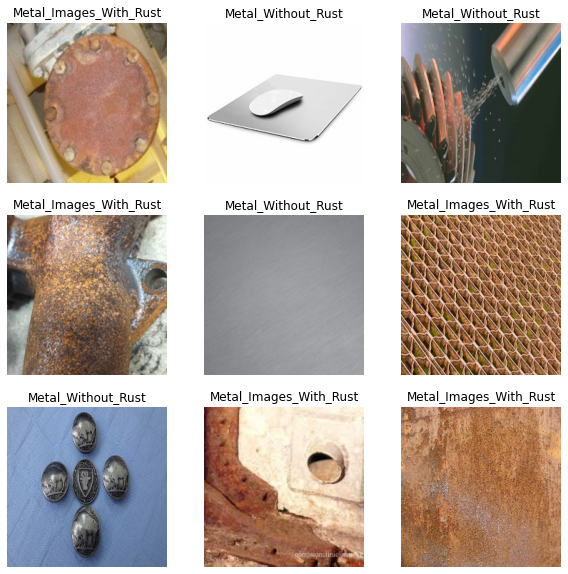

In [48]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

In [49]:
import tensorflow_hub as hub
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(2)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [59]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
history = model.fit_generator(train_ds, epochs=8,
                              steps_per_epoch=np.ceil(300/BATCH_SIZE)
                              ,validation_data=val_f,validation_steps=np.ceil((image_count-300 )/BATCH_SIZE))

Epoch 1/8
10/10 [==============================] - 9s 864ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 0.9896
Epoch 2/8
10/10 [==============================] - 0s 37ms/step - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9896
Epoch 3/8
10/10 [==============================] - 0s 38ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9896
Epoch 4/8
10/10 [==============================] - 0s 39ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 0.9896
Epoch 5/8
10/10 [==============================] - 0s 39ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 0.9896
Epoch 6/8
10/10 [==============================] - 0s 38ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9896
Epoch 7/8
10/10 [==============================] - 0s 38ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9896
Epoch 8/8
10/10 [==============================] - 0s 39ms/step - loss: 0.0023 - acc: 1.0

In [66]:
predicted_batch = model.predict(val_f, steps=np.ceil((image_count-300 )/BATCH_SIZE))
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = CLASS_NAMES[predicted_id]
for image_batch, label_batch in val_f:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


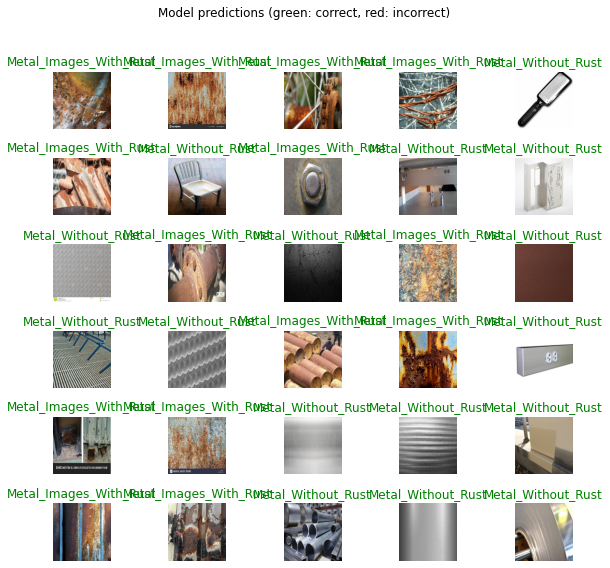

In [68]:
label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")